In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import OptionPricers
reload(OptionPricers)
from OptionPricers import SABR
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Take CMS 5x10 as example (coz part 4 depends on this number)

From part 2 we got the following $K-\sigma$ graph

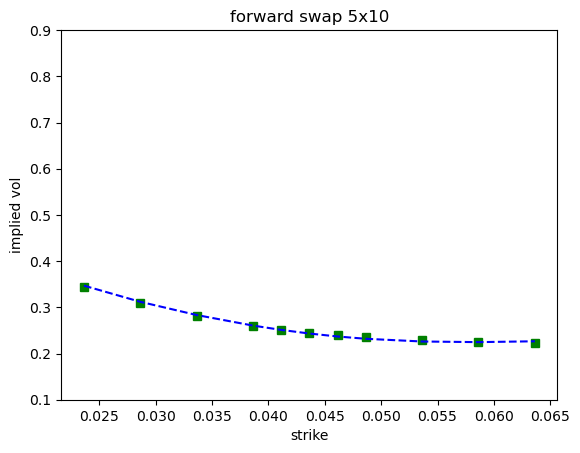

In [8]:
tenor = 10
expiry = 5

# forward swap rates from part 1
swap_rates_df = pd.read_excel("data/swap_rates.xlsx", sheet_name="swap_rates", index_col=0) # expiry x tenor
swap_rates_df.columns = swap_rates_df.columns.astype('int64')
swap_rates_df

# swaption market data
swaption_df = pd.read_excel("data/IR Data.xlsx", sheet_name="Swaption", header=2)
market_vols = swaption_df[(swaption_df['Expiry']=="5Y") & (swaption_df['Tenor']=="10Y")]
market_vols = market_vols.iloc[:,2:].values.reshape(-1)/100

# calibrated SABR params
sabr_alpha_df = pd.read_excel("data/model_calibration.xlsx", sheet_name="sabr_alpha", index_col=0)
sabr_alpha_df.columns = sabr_alpha_df.columns.astype('int64')
sabr_rho_df = pd.read_excel("data/model_calibration.xlsx", sheet_name="sabr_rho", index_col=0)
sabr_rho_df.columns = sabr_rho_df.columns.astype('int64')
sabr_nu_df = pd.read_excel("data/model_calibration.xlsx", sheet_name="sabr_nu", index_col=0)
sabr_nu_df.columns = sabr_nu_df.columns.astype('int64')


F = swap_rates_df[tenor][expiry]
alpha = sabr_alpha_df[tenor][expiry]
rho = sabr_rho_df[tenor][expiry]
nu = sabr_nu_df[tenor][expiry]

__strikes__ = [-200, -150, -100, -50, -25, 0, 25, 50, 100, 150, 200]

plt.plot([F+k*1E-4 for k in __strikes__], 
         market_vols, 's', color='green', label='realized vol')


extended_strikes = __strikes__ + np.linspace(200, 4000, 96).tolist()
plt.plot([F+k*1E-4 for k in __strikes__], 
         [SABR(F, F+k*1E-4, expiry, alpha, 0.9, rho, nu) for k in __strikes__], 
         color='blue', linestyle='--', label=f'SABR model')

plt.ylim(0.1, 0.9)
plt.title("forward swap 5x10")
plt.xlabel("strike")
plt.ylabel("implied vol")

plt.show()

In the provided swaption market data, max strike is +200bps.

So when we calc the integration for static replication
```python
I_pay = quad(lambda x: h_2(x) * Black76Call(F, 
                                            x, 
                                            SABR(F, x, Tn, alpha, beta, rho, nu), 
                                            Tn)
```
we are actually using the calibrated SABR model to "predict" the implied vols for strikes larger than +200bps and plug in the black model to get swaption prices.

If we extend the x axis to check the vols for bigger strikes (from F+200bps to ~10*F)

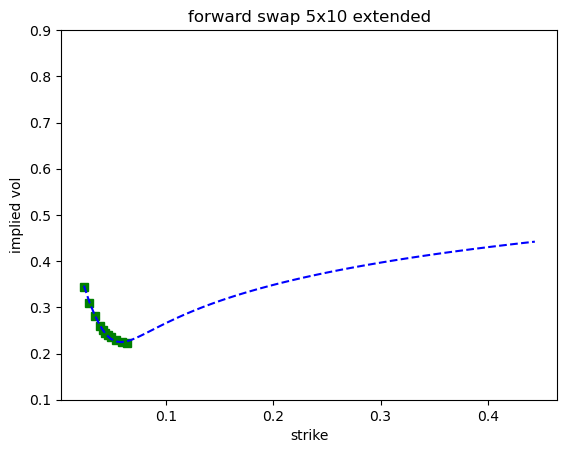

In [7]:
plt.plot([F+k*1E-4 for k in __strikes__], 
         market_vols, 's', color='green', label='realized vol')

extended_strikes = __strikes__ + np.linspace(200, 4000, 96).tolist()
plt.plot([F+k*1E-4 for k in extended_strikes], 
         [SABR(F, F+k*1E-4, expiry, alpha, 0.9, rho, nu) for k in extended_strikes], 
         color='blue', linestyle='--', label=f'SABR model')

plt.ylim(0.1, 0.9)
plt.title("forward swap 5x10 extended")
plt.xlabel("strike")
plt.ylabel("implied vol")

plt.show()

Can see that implied vol grows as strike moves to the right. That's why the integration "explodes" if upper bound not set properly.

ChatGPT's recommended upper bound is $F+4*\sigma \sqrt{T}$. Copied answers here for reference.

In [ ]:
# F and proposed max F
(F, F + 4*SABR(F, F, expiry, alpha, 0.9, rho, nu)/100*np.sqrt(expiry))
# which is quite close to +200bps max market strike

(0.04363364552747547, 0.06539335340884)

### **Q: How to select a reasonable range of strikes for static replication**

Selecting an appropriate range of strikes for static replication is crucial for accurately approximating the target payoff while ensuring numerical stability and computational efficiency. Here’s a structured approach:

---

### **1. Key Considerations**
- **Payoff Function Characteristics**: The payoff function determines how strikes should be weighted.
- **Forward Rate ($F $)**: The current forward CMS rate (e.g., $F = 3\% $) is the natural center of the strike range.
- **Volatility Smile/Skew**: Swaption implied volatilities vary by strike, affecting replication accuracy.
- **Liquidity of Strikes**: Prioritize strikes with liquid market quotes to avoid extrapolation errors.

---

### **2. Strike Range Selection**
#### **(a) Absolute Bounds**
- **Lower Bound ($K_{\text{min}} $)**:  
  - Avoid $K = 0 $ (singularity in $f''(K) = -0.1875 K^{-1.75} $).  
  - Practical choice: $K_{\text{min}} = \max(0.1\%, F - 4\sigma\sqrt{T}) $, where $\sigma $ is ATM volatility.  
  - Example: If $F = 3\% $, $\sigma = 20\% $, $T = 5 $:  
    $K_{\text{min}} \approx 3\% - 4 \times 0.2 \times \sqrt{5} \approx 3\% - 1.8\% = 1.2\% $.

- **Upper Bound ($K_{\text{max}} $)**:  
  - Cover extreme upside scenarios.  
  - <mark>Rule of thumb</mark>: $K_{\text{max}} = F + 4\sigma\sqrt{T} $.
  - Example: $K_{\text{max}} \approx 3\% + 1.8\% = 4.8\% $.

#### **(b) Strike Spacing**
- **Logarithmic Spacing**:  
  - More strikes near $F $ (high gamma region) and fewer in tails.  
  - Example: Use `np.logspace` in Python for $K \in [K_{\text{min}}, K_{\text{max}}] $.  
- **Linear Spacing**:  
  - Simpler but may require more strikes. Suitable for narrow ranges.  
  - Example: `np.linspace(1.2%, 4.8%, 20)`.



### **Q: Why is upper bound $F + 4\sigma\sqrt{T}$**

### **Why $4\sigma$ Covers ~99.99% of a Lognormal Distribution**

The claim that $4\sigma$ covers **99.99%** of the probability mass under a lognormal distribution comes from the **properties of the normal distribution** (since the lognormal is derived from it) and the **empirical rules of standard deviations**. Here’s a detailed breakdown:

---

### **1. Lognormal Distribution Basics**
A random variable $X$ follows a **lognormal distribution** if its natural logarithm $\ln(X)$ is normally distributed.  
- If $\ln(X) \sim \mathcal{N}(\mu, \sigma^2)$, then $X$ has:
  - **Mean (expected value)**: $e^{\mu + \sigma^2/2}$
  - **Variance**: $e^{2\mu + \sigma^2}(e^{\sigma^2} - 1)$

In finance, the **lognormal model** (e.g., Black-Scholes) assumes that asset prices or rates (like CMS rates) follow:
$$
X_T = X_0 e^{(\mu - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z}, \quad Z \sim \mathcal{N}(0,1)
$$
where $Z$ is a standard normal variable.

---

### **2. Confidence Intervals for a Normal Distribution**
For a standard normal distribution $\mathcal{N}(0,1)$:
- $\pm 1\sigma$ covers **~68.27%** of the mass.
- $\pm 2\sigma$ covers **~95.45%**.
- $\pm 3\sigma$ covers **~99.73%**.
- $\pm 4\sigma$ covers **~99.9937%** (effectively 99.99%).

This is why $4\sigma$ is often used as a cutoff for "near-certainty" in statistical applications.

---

### **3. Translating to Lognormal Confidence Intervals**
For the lognormal distribution, confidence intervals are derived from the normal distribution of $\ln(X)$:
$$
P\left( e^{\mu - k\sigma} \leq X \leq e^{\mu + k\sigma} \right) = P\left(-k \leq Z \leq k\right)
$$
where $k$ is the number of standard deviations.  

For example:
- The **95% interval** for $X$ is roughly $[e^{\mu - 2\sigma}, e^{\mu + 2\sigma}]$.
- The **99.99% interval** corresponds to $k \approx 4$:
  $$
  P\left( e^{\mu - 4\sigma} \leq X \leq e^{\mu + 4\sigma} \right) \approx 99.99\%.
  $$

---

### **4. Why $4\sigma$ is Used in Static Replication**
1. **Covering Extreme Moves**  
   - In finance, rates (like CMS) can experience large deviations, especially over long tenors (e.g., $T = 5$ years).  
   - A $4\sigma$ range ensures that even **Black Swan events** (e.g., rate spikes/crashes) are accounted for in the replication.

2. **Numerical Stability**  
   - The weights in static replication depend on $f''(K)$, which decays rapidly for large $K$ (e.g., $K^{-1.75}$).
   - Beyond $4\sigma$, the contributions of swaptions are negligible (weights ≈ 0).

3. **Market Liquidity**  
   - Swaptions with strikes beyond $4\sigma$ are **illiquid** and have minimal premium.  
   - Excluding them simplifies the replication without sacrificing accuracy.

---

### **5. Empirical Validation**
- **For CMS rates**, historical data shows that moves beyond $4\sigma$ are exceedingly rare.  
- **Example**: If $\sigma = 20\%$ and $T = 5$ years:
  $$
  4\sigma\sqrt{T} = 4 \times 0.2 \times \sqrt{5} \approx 1.79.
  $$
  - For $F = 3\%$, the upper bound is $3\% \times e^{1.79} \approx 18.5\%$.  
  - <mark>Rates moving to 18.5% are **extremely unlikely** in most economies.</mark>

---

### **6. Adjustments for Fat Tails**
If the market implies **fat tails** (e.g., via stochastic volatility models), the multiplier can be increased (e.g., $5\sigma$). However:
- For lognormal models, $4\sigma$ is already conservative.
- In practice, rates are often **mean-reverting**, making extreme moves even rarer.

---

### **Conclusion**
The $4\sigma$ rule is a **statistically robust and practically efficient** cutoff because:
1. It captures **99.99% of the lognormal distribution** (based on normal distribution quantiles).  
2. It aligns with **market liquidity** (deep OTM swaptions are irrelevant).  
3. It ensures **numerical stability** in replication (negligible weights beyond this point).  

For most applications in interest rate modeling, $K_{\text{max}} = F + 4\sigma\sqrt{T}$ is a safe and effective choice.

### **Q: But why you use $F + 4\sigma\sqrt{T}$ instead of $F*e^{4σ*\sqrt{T}}$**

Great question! The difference between **additive** ($F + 4σ\sqrt{T}$) and **multiplicative** ($F \cdot e^{4σ\sqrt{T}}$) bounds comes down to the **assumptions about the distribution of the underlying rate** and the **financial context** of the problem. Here’s the breakdown:

---

### **1. Additive vs. Multiplicative Bounds: Key Difference**
- **Additive bound** ($F + 4σ\sqrt{T}$):
  - Implies the rate follows a **normal distribution** (absolute moves are symmetric).  
  - Example: If $F = 3\%$ and $4σ\sqrt{T} = 1.8\%$, the upper bound is $3\% + 1.8\% = 4.8\%$.

- **Multiplicative bound** ($F \cdot e^{4σ\sqrt{T}}$):
  - Implies the rate follows a **lognormal distribution** (relative moves are symmetric).  
  - Example: If $F = 3\%$ and $4σ\sqrt{T} = 1.8$, the upper bound is $3\% \cdot e^{1.8} \approx 18.1\%$.

---

### **2. Why Use $F + 4σ\sqrt{T}$ for CMS Replication?**
#### **(a) CMS Rates Are Not Strictly Lognormal**
- While **swap rates** (and thus CMS rates) are often modeled as lognormal in derivatives pricing (e.g., Black’s model for swaptions), their actual behavior is closer to **normal** for moderate rates (e.g., 1–10%).  
- This is because:
  - Rates cannot go negative (supporting lognormal), but they also rarely explode to extremely high values (unlike stock prices).
  - Empirical studies show that **rate changes are better approximated by additive moves** in normal markets.

#### **(b) Numerical Stability**
- The payoff $ \text{CMS}^{0.25} $ has rapidly decaying sensitivity at high strikes ($f''(K) \sim K^{-1.75}$).  
- Using $F + 4σ\sqrt{T}$ avoids extreme strikes (e.g., 18% in the multiplicative case), where:
  - Swaptions are **illiquid** or **nonexistent**.
  - Weights become **negligible** but introduce numerical noise.

#### **(c) Market Conventions**
- Swaption markets often quote implied volatilities in **normal (bps) terms** for rates, especially in low-rate environments.  
- The additive bound aligns with trader intuition (e.g., "rates might move ±200 bps").

---

### **3. When Would You Use $F \cdot e^{4σ\sqrt{T}}$?**
- For **strictly positive, exponentially growing underlyings** (e.g., stock prices, FX rates).  
- In **high-inflation environments**, where rates could theoretically explode multiplicatively.  
- If explicitly modeling rates as lognormal (e.g., Black-76 swaption model).

---

### **4. Practical Example**
For $F = 3\%$, $σ = 20\%$, $T = 5$ years:
- **Additive bound**:  
  $
  3\% + 4 \times 0.2 \times \sqrt{5} \approx 3\% + 1.8\% = 4.8\%.
  $  
  - Covers moves up to ~4.8%, which is realistic for rates.  
  - Swaptions at 4.8% may still trade (if illiquid, extrapolate).  

- **Multiplicative bound**:  
  $
  3\% \cdot e^{1.8} \approx 18.1\%.
  $  
  - A 10-year swap rate of 18% is **implausible** in most economies.  
  - Swaptions at 18% would have **zero liquidity** and contribute nothing to replication.

---

### **5. Compromise: Displaced Diffusion**
Some models blend additive and multiplicative behavior using a **displaced diffusion** process:
$$
dS_t = \sigma (S_t + a) dW_t,
$$
where $a$ controls the mix.  
- For $a = 0$: Lognormal.  
- For large $a$: Normal.  

This can justify a **hybrid bound** like $F + a(e^{4σ\sqrt{T}} - 1)$, but adds complexity.

---

### **Conclusion**
For CMS rate replication:
- **Use $F + 4σ\sqrt{T}$** (additive):  
  Matches empirical rate behavior, avoids extreme strikes, and aligns with market conventions.  
- **Avoid $F \cdot e^{4σ\sqrt{T}}$** (multiplicative):  
  Overestimates plausible rate moves and introduces impractical strikes.  

**Exception**: If explicitly modeling rates as lognormal (e.g., in a Black-76 framework), use multiplicative bounds—but even then, truncate at a realistic maximum rate (e.g., 10%).